## Try phase association for stations on 10/14/2012
Refernce: https://github.com/yetinam/pyocto

In [1]:
# !pip3 install numpy
# !pip3 install pyrocko

In [383]:
import pyocto
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from scipy import signal
from obspy.signal.trigger import classic_sta_lta

from obspy.clients.fdsn import Client
from obspy.core.utcdatetime import UTCDateTime
from pnwstore.mseed import WaveformClient


In [105]:
# Import the velocity model from https://colab.research.google.com/github/yetinam/pyocto/blob/main/examples/02_velocity_models.ipynb#scrollTo=1c52ed9e-d9c1-4fa6-a549-de702bc9d439
# !wget https://github.com/yetinam/pyocto/raw/main/tests/data/graeber.csv

## Input Data

In [106]:
picks = pd.read_csv("~/notebooks/data/phase_association/20121014/picks_20121014.csv",index_col=0)
stations = pd.read_csv("~/notebooks/data/phase_association/20121014/stations_20121014.csv",index_col=0)

In [107]:
picks

,station,phase,time
0,FS09B,P,2012-10-14T00:05:57.814700Z
1,FS09B,P,2012-10-14T00:26:31.574700Z
2,FS09B,P,2012-10-14T00:37:17.174700Z
3,FS09B,P,2012-10-14T00:39:52.134700Z
4,FS09B,P,2012-10-14T00:47:23.734700Z
...,...,...,...
2067,M14B,S,2012-10-14T22:24:36.789869Z
2068,M14B,S,2012-10-14T22:26:19.909869Z
2069,M14B,S,2012-10-14T23:29:58.769869Z
2070,M14B,S,2012-10-14T23:32:10.929869Z


In [108]:
stations

,id,longitude,latitude,elevation
0,FS09B,-124.808502,40.438702,-2161.0
1,G10B,-125.553299,40.677898,-2936.0
2,G19B,-125.773598,41.307400,-3071.0
3,G25B,-124.586098,41.919899,-430.0
4,G27B,-126.016701,41.916599,-3480.0
5,J09B,-124.726997,43.151001,-252.0
6,M12B,-124.946098,42.183998,-1045.0
7,M14B,-124.589699,40.985001,-638.0


  ## Velocoty Models

In [109]:
velocity_model = pyocto.VelocityModel0D(
    p_velocity=7.0,
    s_velocity=4.0,
    tolerance=2.0,
)

In [110]:
?pyocto.OctoAssociator.from_area

## Create a 1D velocity model

In [85]:
# layers = pd.read_csv("graeber.csv")
# layers

In [86]:
# model_path = "velocity_model"
# pyocto.VelocityModel1D.create_model(layers, 1., 400, 250, model_path)

In [87]:
# velocity_model_1d = pyocto.VelocityModel1D(model_path, tolerance=2.0)

## The OctoAssociator class

In [111]:
associator = pyocto.OctoAssociator.from_area(
    lat=(40, 43.5),
    lon=(-126.5, -123),
    zlim=(0, 50),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=4,
    n_p_picks=3,
    n_s_picks=1,
    n_p_and_s_picks=1,
)

In [112]:
associator.crs

<Projected CRS: +proj=tmerc +lat_0=41.75 +lon_0=-124.75 +units=km  ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (kilometre)
- N[north]: Northing (kilometre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [113]:
associator.transform_stations(stations)
stations

,id,longitude,latitude,elevation,x,y,z
0,FS09B,-124.808502,40.438702,-2161.0,-4.963595,-145.625525,2.161
1,G10B,-125.553299,40.677898,-2936.0,-67.913996,-118.755232,2.936
2,G19B,-125.773598,41.307400,-3071.0,-85.719842,-48.651523,3.071
3,G25B,-124.586098,41.919899,-430.0,13.596424,18.883688,0.430
4,G27B,-126.016701,41.916599,-3480.0,-105.085006,19.280241,3.480
5,J09B,-124.726997,43.151001,-252.0,1.871087,155.626312,0.252
6,M12B,-124.946098,42.183998,-1045.0,-16.199984,48.223921,1.045
7,M14B,-124.589699,40.985001,-638.0,13.490014,-84.949193,0.638


## Convert the timestamps to floats

In [114]:
picks["time"] = picks["time"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%fZ'))

In [115]:
picks["time"] = picks["time"].apply(lambda x: x.timestamp())
picks

,station,phase,time
0,FS09B,P,1.350173e+09
1,FS09B,P,1.350174e+09
2,FS09B,P,1.350175e+09
3,FS09B,P,1.350175e+09
4,FS09B,P,1.350176e+09
...,...,...,...
2067,M14B,S,1.350253e+09
2068,M14B,S,1.350254e+09
2069,M14B,S,1.350257e+09
2070,M14B,S,1.350258e+09


In [116]:
type(1.349050e+09)

float

## Delete unnecessary columns

In [117]:
# picks.drop(columns="Unnamed: 0", inplace=True)
# picks

In [118]:
# stations.drop(columns="Unnamed: 0", inplace=True)
# stations

## Apply  the associator

In [119]:
events, assignments = associator.associate(picks, stations)

In [120]:
events

,idx,time,x,y,z,picks
0,0,1.350178e+09,-99.823478,8.014299,24.609375,4
1,1,1.350182e+09,26.269336,-128.412984,40.234375,5
2,2,1.350184e+09,12.259024,-107.072404,49.609375,7
3,3,1.350197e+09,-18.096654,-97.926441,19.140625,4
4,4,1.350201e+09,-89.315744,-138.321111,36.328125,14
5,5,1.350216e+09,-18.096654,27.830552,1.171875,4
6,6,1.350226e+09,-75.305431,-127.650821,28.515625,4
7,7,1.350234e+09,-60.127592,-121.553512,37.890625,14
8,8,1.350239e+09,61.295118,-104.785913,8.984375,4
9,9,1.350244e+09,6.421393,-62.104752,1.171875,4


In [121]:
Counter(events['picks'])

Counter({4: 6, 14: 2, 5: 1, 7: 1})

In [122]:
associator.transform_events(events)
events["time"] = events["time"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc)
events

,idx,time,x,y,z,picks,latitude,longitude,depth
0,0,2012-10-14 01:24:03.676530+00:00,-99.823478,8.014299,24.609375,4,41.815873,-125.951392,24.609375
1,1,2012-10-14 02:39:44.924554+00:00,26.269336,-128.412984,40.234375,5,40.593306,-124.439672,40.234375
2,2,2012-10-14 03:08:04.522444+00:00,12.259024,-107.072404,49.609375,7,40.785806,-124.604763,49.609375
3,3,2012-10-14 06:39:14.450545+00:00,-18.096654,-97.926441,19.140625,4,40.868056,-124.964663,19.140625
4,4,2012-10-14 07:45:27.532755+00:00,-89.315744,-138.321111,36.328125,14,40.499693,-125.803638,36.328125
5,5,2012-10-14 12:02:37.496525+00:00,-18.096654,27.830552,1.171875,4,42.000358,-124.968426,1.171875
6,6,2012-10-14 14:38:21.428889+00:00,-75.305431,-127.650821,28.515625,4,40.597160,-125.639653,28.515625
7,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.460940,37.890625
8,8,2012-10-14 18:16:43.973209+00:00,61.295118,-104.785913,8.984375,4,40.804200,-124.023617,8.984375
9,9,2012-10-14 19:52:13.871130+00:00,6.421393,-62.104752,1.171875,4,41.190790,-124.673457,1.171875


In [425]:
events.to_csv('~/notebooks/src/association_events.csv')

In [123]:
assignments

,event_idx,pick_idx,residual,station,phase,time
0,0,283,-0.006772,G19B,P,1.350178e+09
1,0,843,0.125995,G27B,P,1.350178e+09
2,0,1053,-0.261009,M12B,P,1.350178e+09
3,0,1938,0.141786,M12B,S,1.350178e+09
4,1,12,0.377781,FS09B,P,1.350182e+09
...,...,...,...,...,...,...
59,8,2047,-0.029840,M14B,S,1.350239e+09
60,9,163,1.220861,FS09B,P,1.350244e+09
61,9,1579,-0.811171,FS09B,S,1.350244e+09
62,9,257,-0.000484,G10B,P,1.350244e+09


In [124]:
pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))

,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick
0,0,2012-10-14 01:24:03.676530+00:00,-99.823478,8.014299,24.609375,4,41.815873,-125.951392,24.609375,0,283,-0.006772,G19B,P,1.350178e+09
1,0,2012-10-14 01:24:03.676530+00:00,-99.823478,8.014299,24.609375,4,41.815873,-125.951392,24.609375,0,843,0.125995,G27B,P,1.350178e+09
2,0,2012-10-14 01:24:03.676530+00:00,-99.823478,8.014299,24.609375,4,41.815873,-125.951392,24.609375,0,1053,-0.261009,M12B,P,1.350178e+09
3,0,2012-10-14 01:24:03.676530+00:00,-99.823478,8.014299,24.609375,4,41.815873,-125.951392,24.609375,0,1938,0.141786,M12B,S,1.350178e+09
4,1,2012-10-14 02:39:44.924554+00:00,26.269336,-128.412984,40.234375,5,40.593306,-124.439672,40.234375,1,12,0.377781,FS09B,P,1.350182e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,8,2012-10-14 18:16:43.973209+00:00,61.295118,-104.785913,8.984375,4,40.804200,-124.023617,8.984375,8,2047,-0.029840,M14B,S,1.350239e+09
60,9,2012-10-14 19:52:13.871130+00:00,6.421393,-62.104752,1.171875,4,41.190790,-124.673457,1.171875,9,163,1.220861,FS09B,P,1.350244e+09
61,9,2012-10-14 19:52:13.871130+00:00,6.421393,-62.104752,1.171875,4,41.190790,-124.673457,1.171875,9,1579,-0.811171,FS09B,S,1.350244e+09
62,9,2012-10-14 19:52:13.871130+00:00,6.421393,-62.104752,1.171875,4,41.190790,-124.673457,1.171875,9,257,-0.000484,G10B,P,1.350244e+09


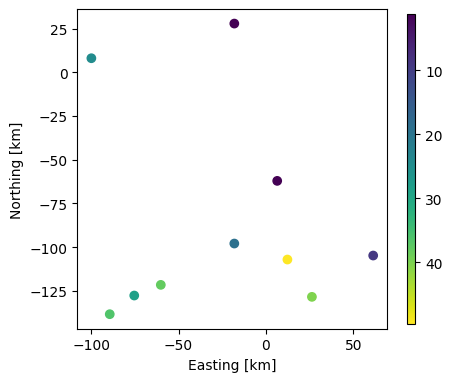

In [125]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

# ax.scatter(events["x"], events["y"], c=events["z"])
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["x"], events["y"], c=events["z"],cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()

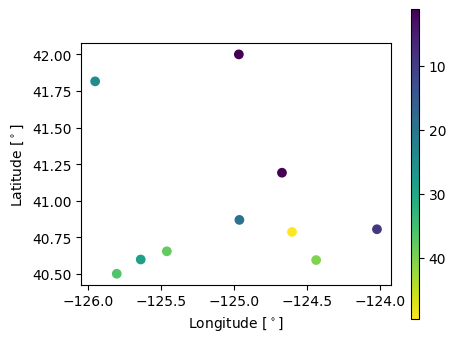

In [126]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

ax.set_xlabel("Longitude [$^\circ$]")
ax.set_ylabel("Latitude [$^\circ$]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["longitude"], events["latitude"], c=events["z"],cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()

## Association validation
Get the events from the USGS and compare with the events from the association


In [46]:
client = Client("USGS")
client_waveforms = WaveformClient()
client.get_events(starttime = UTCDateTime("2012-10-14T00:00:00.000000"),
                  endtime   = UTCDateTime("2012-10-14T23:59:59.999999"),
                  minlatitude = 40, maxlatitude = 44, 
                  minlongitude = -125, maxlongitude = -120)


2 Event(s) in Catalog:
2012-10-14T03:08:01.290000Z | +40.721, -124.210 | 1.74 md | manual
2012-10-14T02:39:45.510000Z | +40.301, -124.416 | 1.49 md | manual

In [57]:
# Pick a station 
s = client_waveforms.get_waveforms(network="7D", station="FS09B", channel="BH?", year=2012, month=10, day=14)
s.filter(type='bandpass',freqmin=4,freqmax=15)

3 Trace(s) in Stream:
7D.FS09B..BH1 | 2012-10-14T00:00:00.014700Z - 2012-10-14T23:59:59.994700Z | 50.0 Hz, 4320000 samples
7D.FS09B..BH2 | 2012-10-14T00:00:00.014700Z - 2012-10-14T23:59:59.994700Z | 50.0 Hz, 4320000 samples
7D.FS09B..BHZ | 2012-10-14T00:00:00.014700Z - 2012-10-14T23:59:59.994700Z | 50.0 Hz, 4320000 samples

In [58]:
# Pick a time that shows up in both the USGS catalog and the event data frame from the association above 
time1 = events.loc[1, 'time']

In [59]:
time1

Timestamp('2012-10-14 02:39:44.924554+0000', tz='UTC')

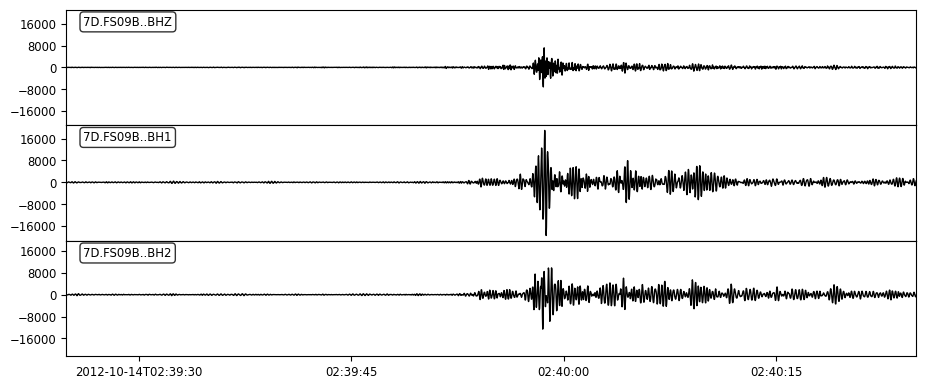

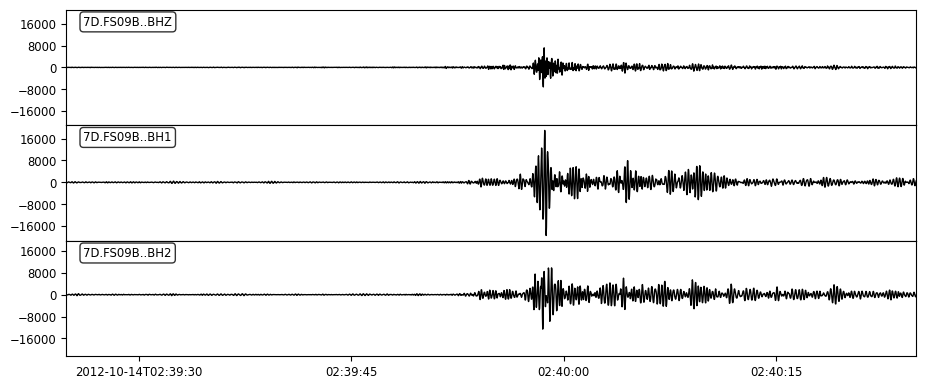

In [60]:
trim_s = s.copy().trim(starttime = UTCDateTime(time1) - 20, 
                endtime = UTCDateTime(time1) + 40)
fig = plt.figure(figsize = (10, 4))
trim_s.plot(fig=fig)

# [ax.axvline(pick.peak_time.matplotlib_date, 
#             linestyle = '--', color = 'r', label = f'{pick.phase} pick') for ax in fig.axes]
# [ax.legend() for ax in fig.axes]

In [61]:
# Pick another time that shows up in both the USGS catalog and the event data frame from the association above 
time2 = events.loc[2, 'time']
time2

Timestamp('2012-10-14 03:08:04.522444+0000', tz='UTC')

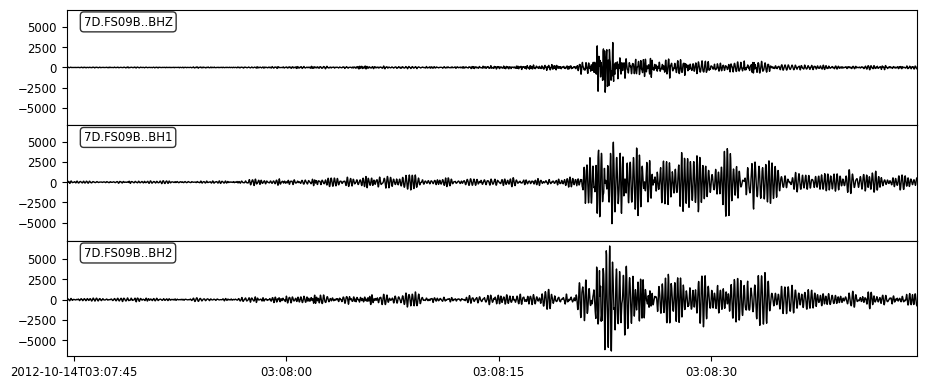

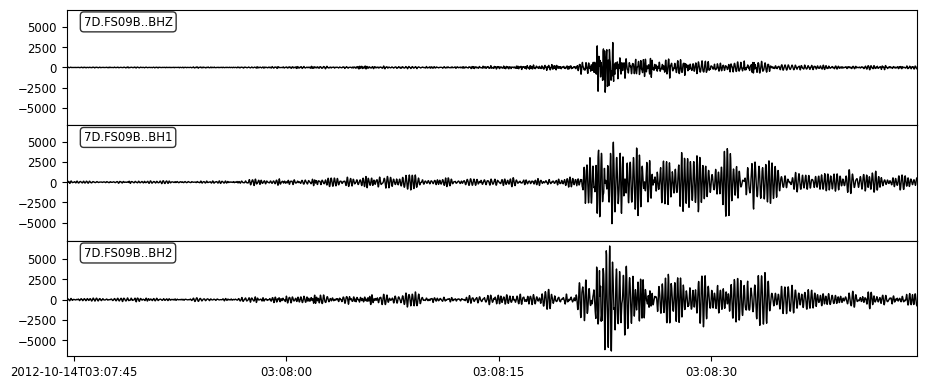

In [63]:
trim_s = s.copy().trim(starttime = UTCDateTime(time2) - 20, 
                endtime = UTCDateTime(time2) + 40)
fig = plt.figure(figsize = (10, 4))
trim_s.plot(fig=fig)

# [ax.axvline(pick.peak_time.matplotlib_date, 
#             linestyle = '--', color = 'r', label = f'{pick.phase} pick') for ax in fig.axes]
# [ax.legend() for ax in fig.axes]

## Other Picks

In [420]:
time = events['time']
time

0   2012-10-14 01:24:03.676530+00:00
1   2012-10-14 02:39:44.924554+00:00
2   2012-10-14 03:08:04.522444+00:00
3   2012-10-14 06:39:14.450545+00:00
4   2012-10-14 07:45:27.532755+00:00
5   2012-10-14 12:02:37.496525+00:00
6   2012-10-14 14:38:21.428889+00:00
7   2012-10-14 16:53:05.638758+00:00
8   2012-10-14 18:16:43.973209+00:00
9   2012-10-14 19:52:13.871130+00:00
Name: time, dtype: datetime64[ns, UTC]

In [418]:
time_possibly_new_events = time.drop(labels=[1,2], axis=0)
time_possibly_new_events

0   2012-10-14 01:24:03.676530+00:00
3   2012-10-14 06:39:14.450545+00:00
4   2012-10-14 07:45:27.532755+00:00
5   2012-10-14 12:02:37.496525+00:00
6   2012-10-14 14:38:21.428889+00:00
7   2012-10-14 16:53:05.638758+00:00
8   2012-10-14 18:16:43.973209+00:00
9   2012-10-14 19:52:13.871130+00:00
Name: time, dtype: datetime64[ns, UTC]

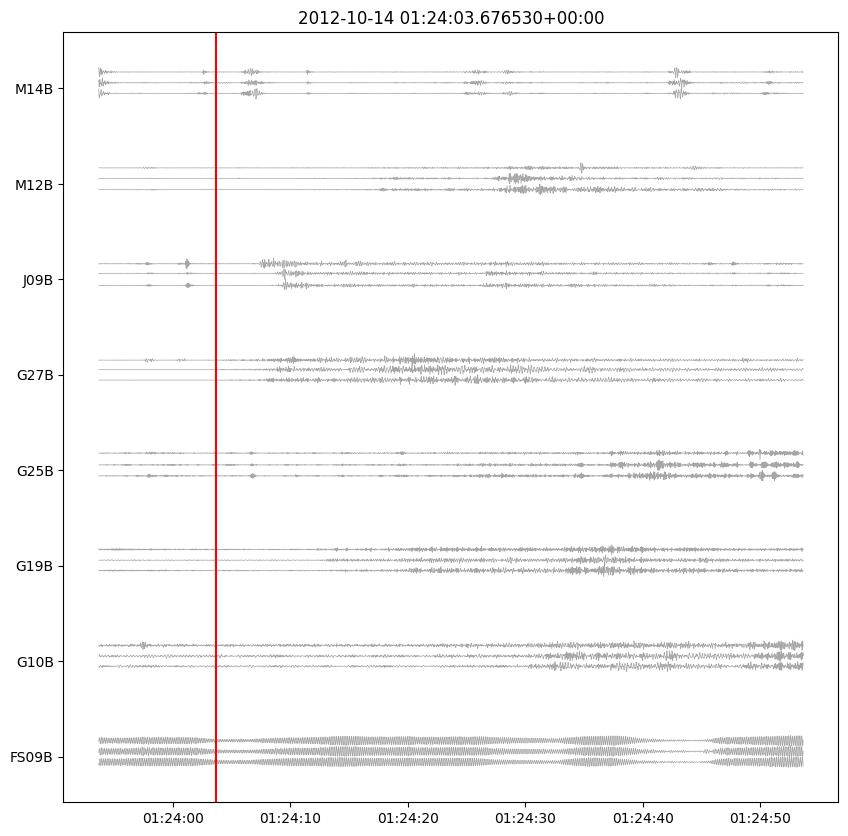

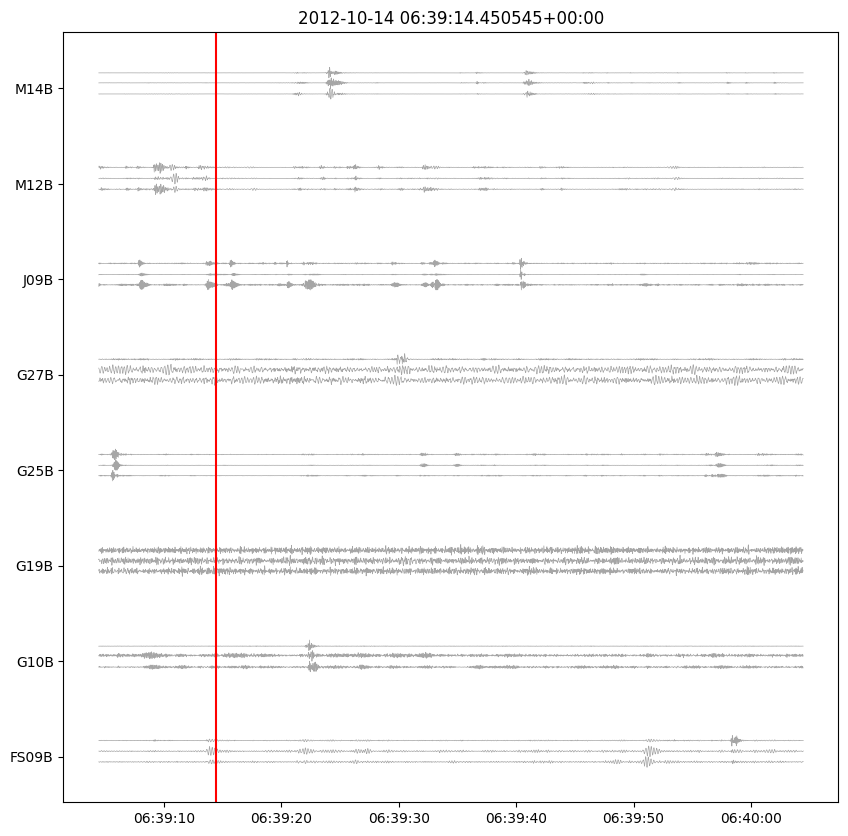

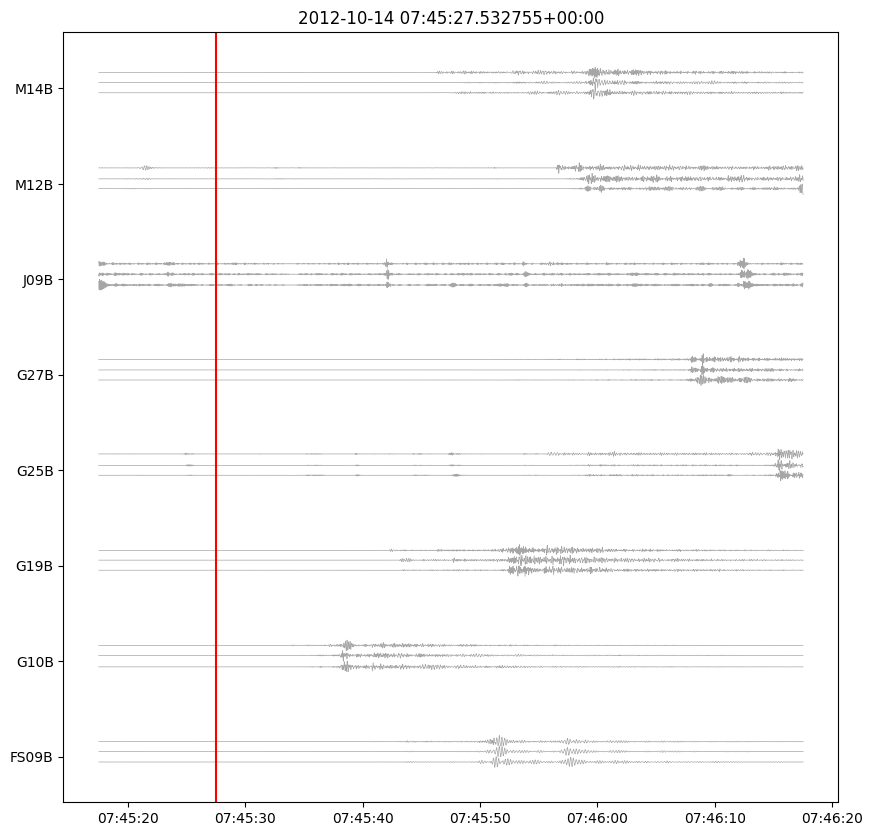

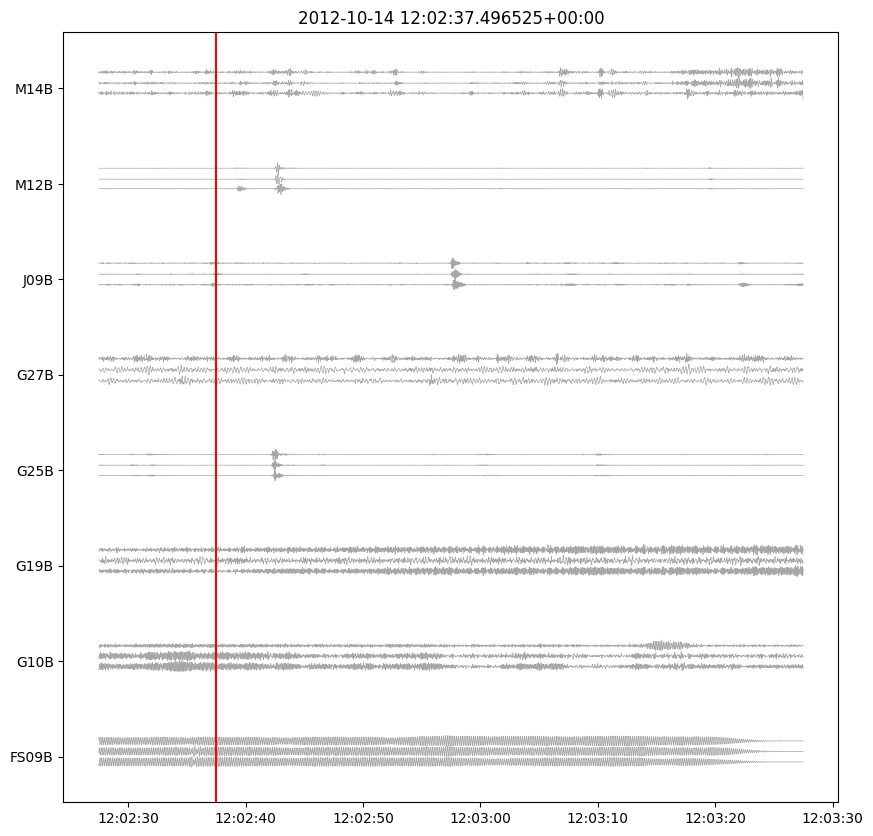

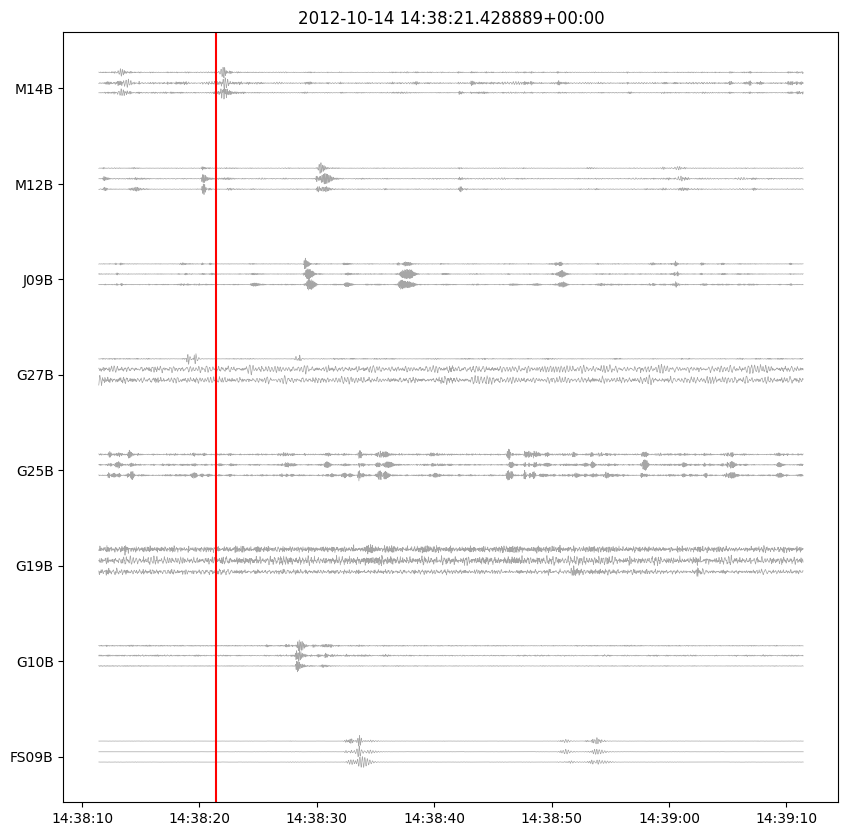

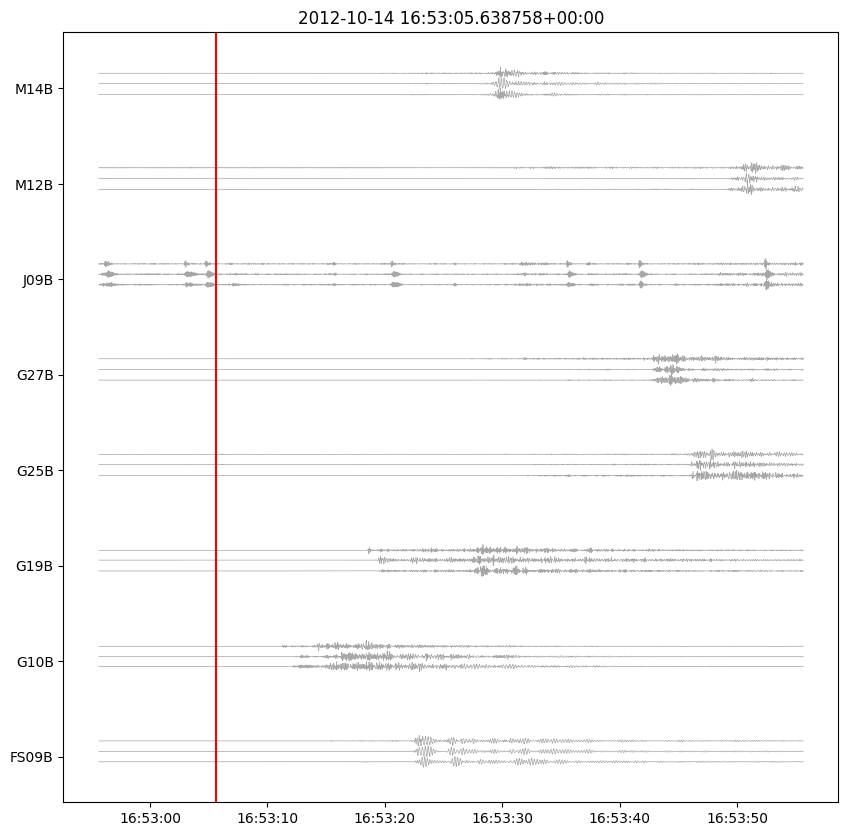

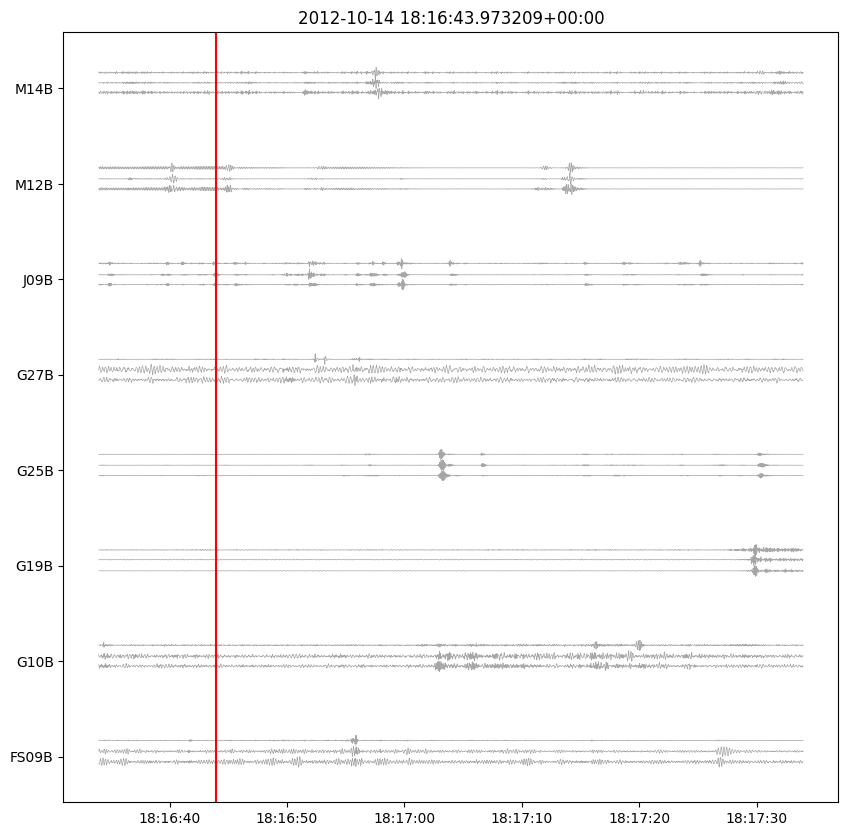

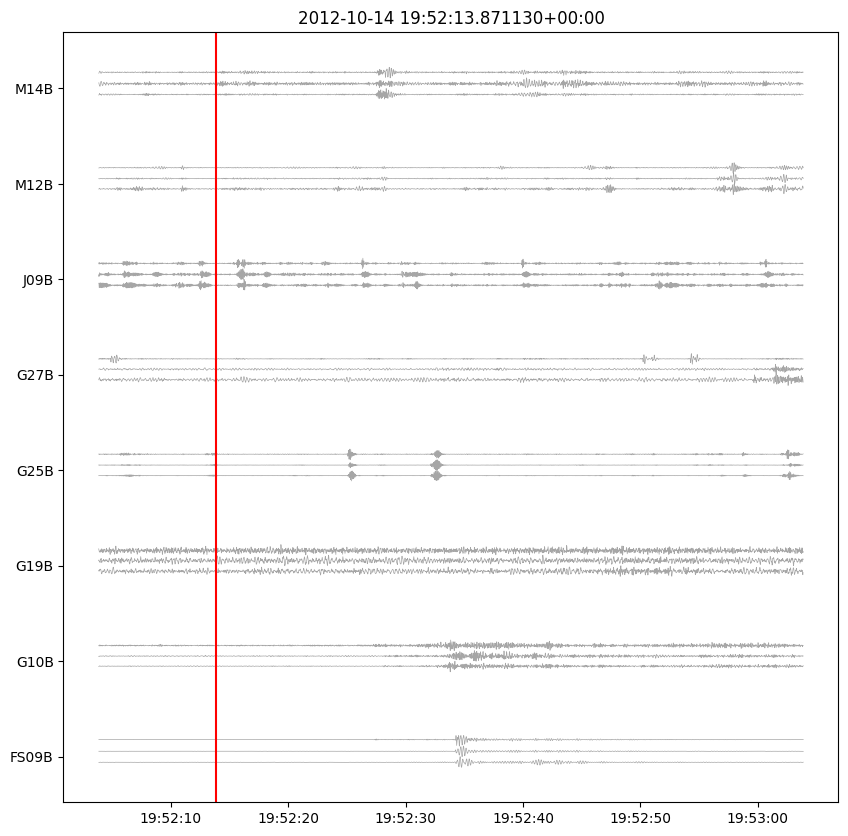

In [421]:
for time in time_possibly_new_events:
    plt.figure(figsize=(10,10))
    for i in range(len(stations)):
        s = client_waveforms.get_waveforms(network="7D", station=stations['id'][i], channel="?H?", year=2012, month=10, day=14)
        s = s.select(channel = "[HB]H?")
        s.filter(type='bandpass',freqmin=4,freqmax=15)
        if s[0].stats.channel == 'HH1':
            s = s.resample(50)
        else:
            pass 

        trim_s = s.copy().trim(starttime = UTCDateTime(time) - 10, endtime = UTCDateTime(time) + 50)
        sdata = np.array(trim_s)[:,:]
        sdata_norm = (sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))
        offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

        for ii in range(len(sdata)):
            offsets1  = np.arange(0,len(sdata))
            plt.plot(trim_s[ii].times(type='utcdatetime'), sdata_norm[ii]+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.7, lw=0.5)    


    plt.yticks(offsets2+1, stations['id'])
    plt.axvline(time,ls='-', c='r')
    plt.title(time)

In [127]:
# Plot waveforms of events picked by the associator but not on the USGS catalog
time4 = events.loc[4, 'time']
time4

Timestamp('2012-10-14 07:45:27.532755+0000', tz='UTC')

In [128]:
# s_FS09B = client_waveforms.get_waveforms(network="7D", station="FS09B", channel="BH?", year=2012, month=10, day=14)
# s_G10B = client_waveforms.get_waveforms(network="7D", station="G10B", channel="BH?", year=2012, month=10, day=14)
# s_G19B = client_waveforms.get_waveforms(network="7D", station="G19B", channel="BH?", year=2012, month=10, day=14)
# s_G25B = client_waveforms.get_waveforms(network="7D", station="G25B", channel="BH?", year=2012, month=10, day=14)
# s_G27B = client_waveforms.get_waveforms(network="7D", station="G27B", channel="BH?", year=2012, month=10, day=14)
# s_J09B = client_waveforms.get_waveforms(network="7D", station="J09B", channel="BH?", year=2012, month=10, day=14)
# s_M12B= client_waveforms.get_waveforms(network="7D", station="M12B", channel="BH?", year=2012, month=10, day=14)
# s_M14B = client_waveforms.get_waveforms(network="7D", station="M14B", channel="BH?", year=2012, month=10, day=14)


In [129]:
# trim_s_FS09B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_G10B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_G19B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_G25B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_G27B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_J09B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_M12B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_M14B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)



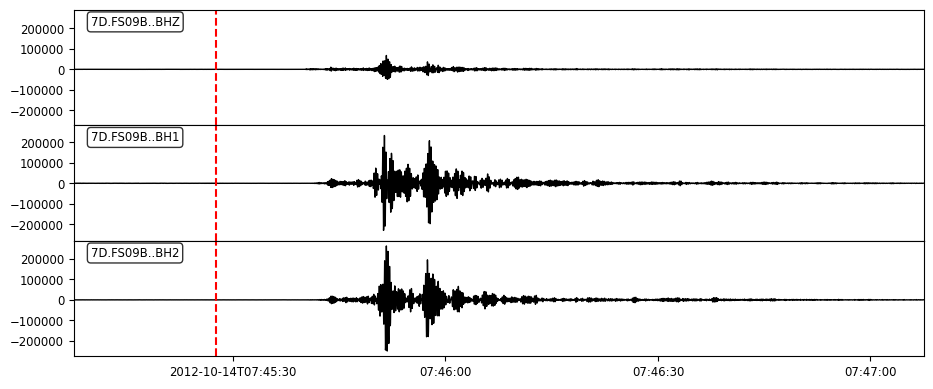

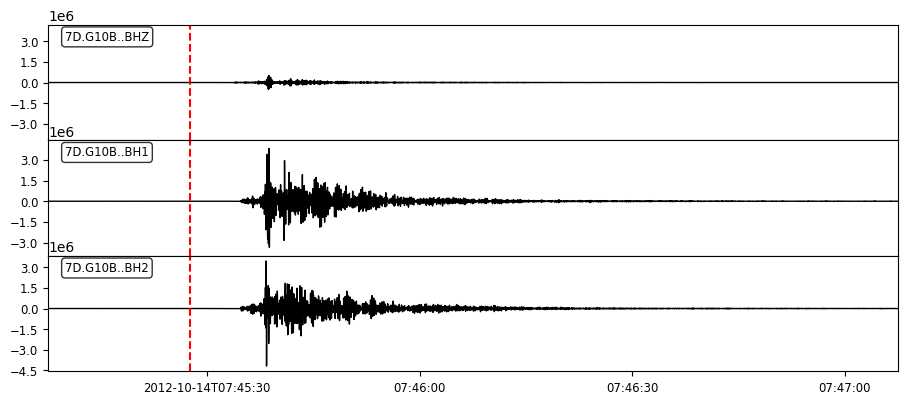

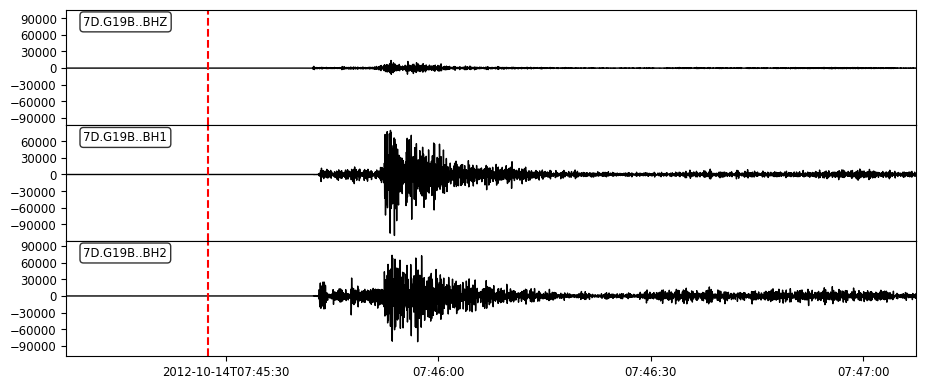

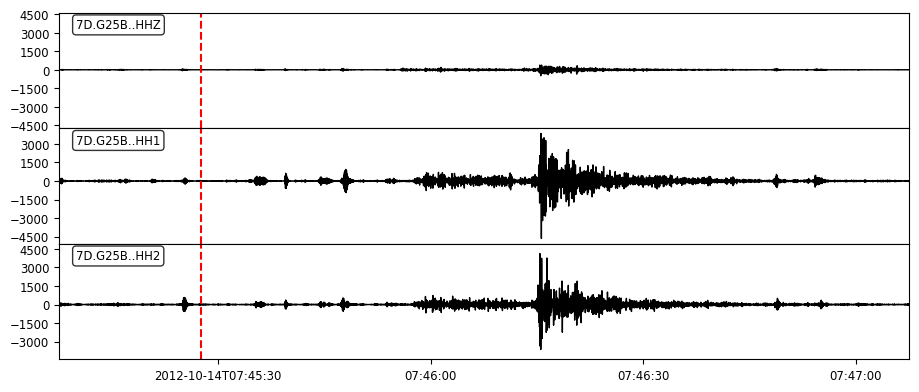

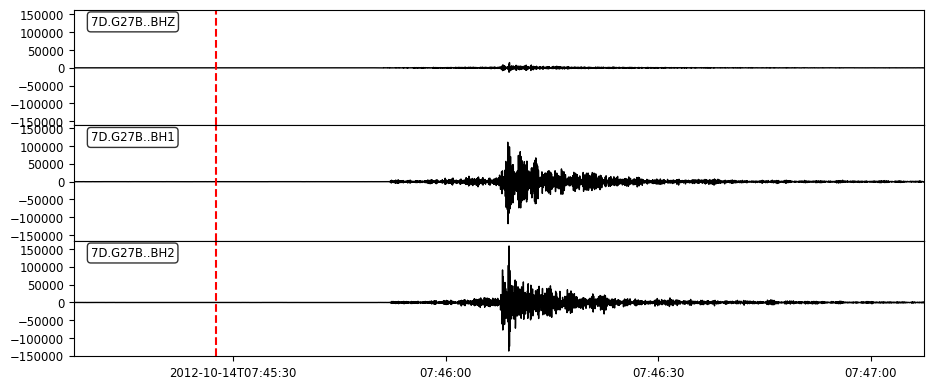

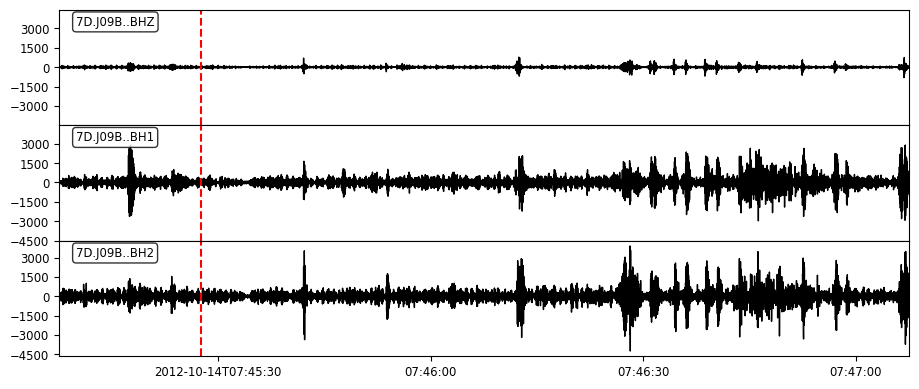

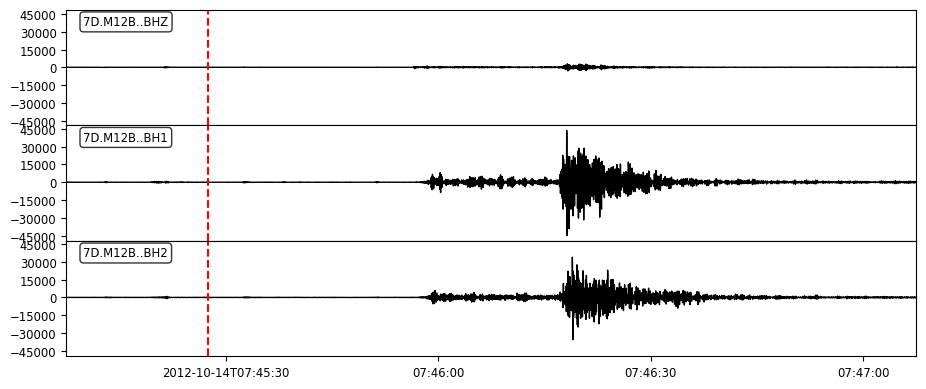

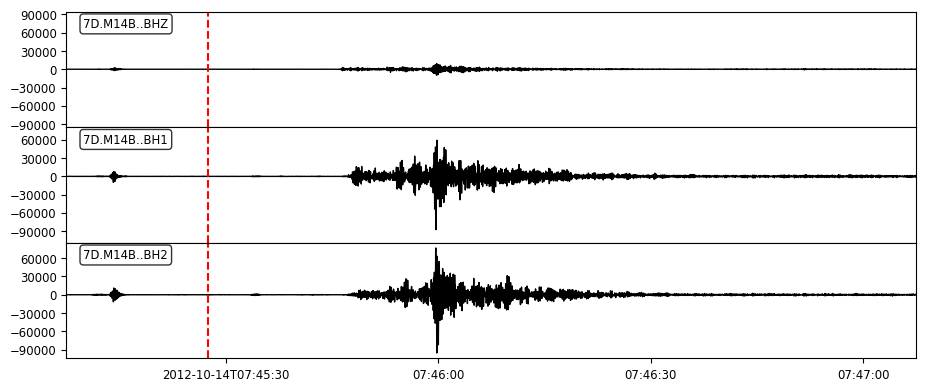

In [174]:
for i, station in enumerate(stations['id']):
    s = client_waveforms.get_waveforms(network="7D", station=station, channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 20, endtime = UTCDateTime(pick_time[4]) + 100)
    fig = plt.figure(figsize=(10,4))
    trim_s.plot(fig=fig)
    [ax.axvline(pick_time[4], 
            linestyle = '--', color = 'r', label = 'pick time') for ax in fig.axes]    


In [190]:
offsets1  = np.arange(0,3)
offsets2 = np.arange(0,2*len(stations),2)



In [191]:
offsets1

array([0, 1, 2])

In [213]:
offsets2 = np.arange(0,2*10000*len(stations),2*10000)

offsets2

array([     0,  20000,  40000,  60000,  80000, 100000, 120000, 140000])

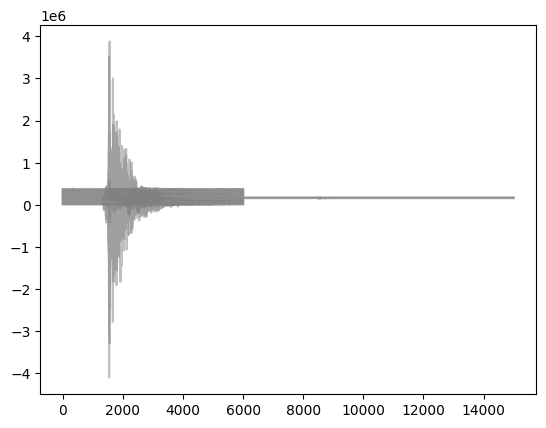

In [216]:
plt.figure()
offsets2 = np.arange(0,5*10000*len(stations),5*10000)

for i, station in enumerate(stations['id']):
    s = client_waveforms.get_waveforms(network="7D", station=station, channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 20, endtime = UTCDateTime(pick_time[4]) + 100)
    sdata = np.array(trim_s)[:,:]
    for ii in range(len(sdata)):
        offsets1  = np.arange(0,10000*len(sdata),10000)
        plt.plot(sdata[ii].T+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.5)   


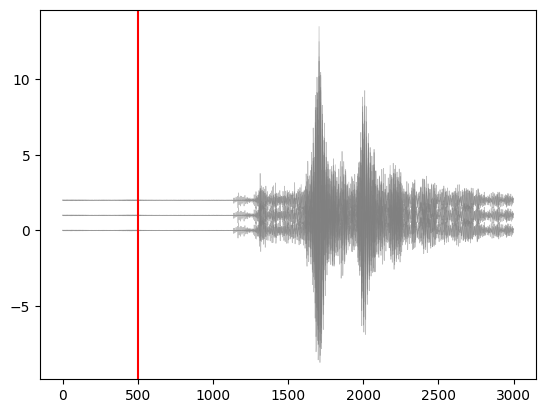

In [285]:
offsets2 = np.arange(0,5*100000*len(stations),5*100000)


s = client_waveforms.get_waveforms(network="7D", station=stations['id'][0], channel="?H?", year=2012, month=10, day=14)
s = s.select(channel = "[HB]H?")
s.filter(type='bandpass',freqmin=4,freqmax=15)
sampling_rate = s[0].stats.sampling_rate
trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
sdata = np.array(trim_s)[:,:]
sdata_norm = (sdata - np.mean(sdata, axis=1, keepdims=True))/(np.std(sdata, axis=1, keepdims=True))

for ii in range(len(sdata)):
    offsets1  = np.arange(0,len(sdata))
    plt.plot(sdata_norm.T+offsets1[ii], color = 'gray', alpha=0.5, lw=0.5)

plt.axvline(10*sampling_rate,ls='-', c='r')
    


In [246]:
sdata.mean()

0.10028120015905434

In [202]:
s[0].stats.sampling_rate*120

6000.0

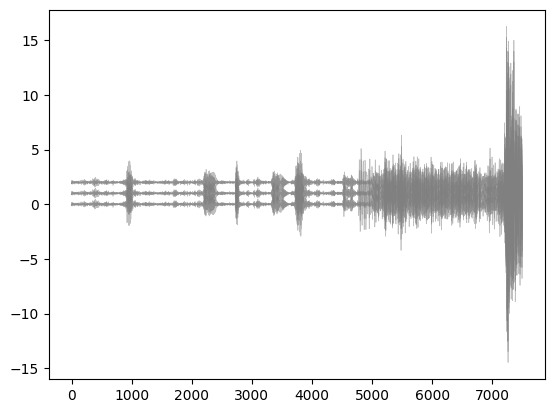

In [296]:
s = client_waveforms.get_waveforms(network="7D", station=stations['id'][3], channel="?H?", year=2012, month=10, day=14)
s = s.select(channel = "[HB]H?")
s.filter(type='bandpass',freqmin=4,freqmax=15)
trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
sdata = np.array(trim_s)[:,:]
sdata_norm = (sdata - np.mean(sdata, axis=1, keepdims=True))/(np.std(sdata, axis=1, keepdims=True))

for ii in range(len(sdata)):
    offsets1  = np.arange(0,len(sdata))
    plt.plot(sdata_norm.T+offsets1[ii], color = 'gray', alpha=0.5, lw=0.5)

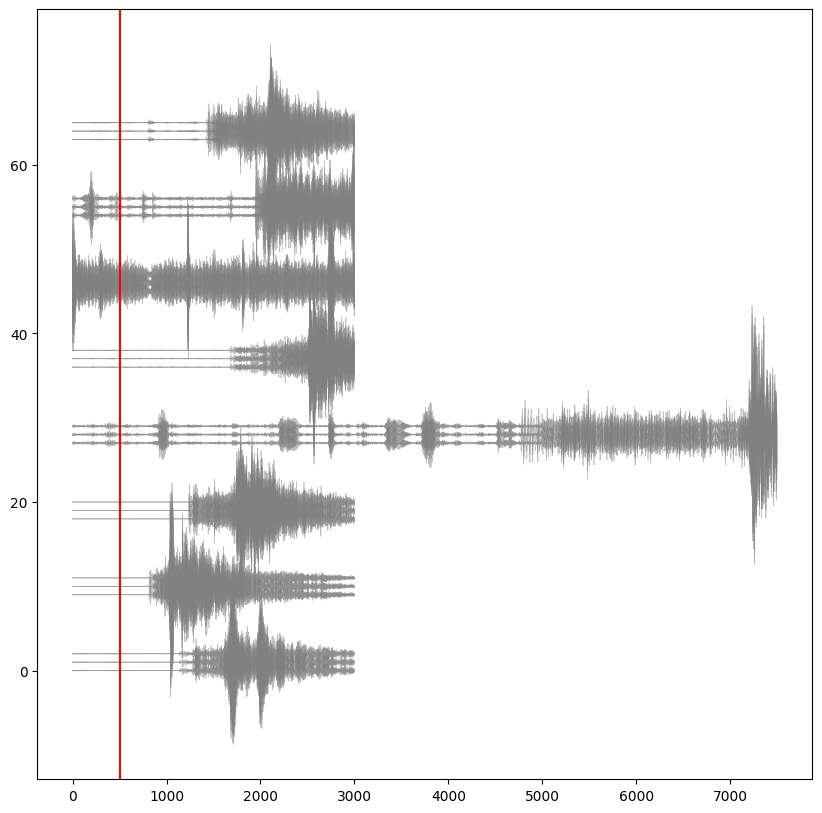

In [293]:
plt.figure(figsize=(10,10))
offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

for i in range(len(stations)):
    s = client_waveforms.get_waveforms(network="7D", station=stations['id'][i], channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
    sdata = np.array(trim_s)[:,:]
    sdata_norm = (sdata - np.mean(sdata, axis=1, keepdims=True))/(np.std(sdata, axis=1, keepdims=True))

    for ii in range(len(sdata)):
        offsets1  = np.arange(0,len(sdata))
        plt.plot(sdata_norm.T+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.5, lw=0.5)    

plt.axvline(10*sampling_rate,ls='-', c='r')


In [289]:
offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))
offsets2

array([ 0,  9, 18, 27, 36, 45, 54, 63])

In [257]:
np.mean(sdata, axis=1, keepdims=True)

array([[ 0.28159811],
       [ 0.08107856],
       [-0.06183307]])

In [258]:
sdata

array([[ 225.73644077,  572.92599194,  565.73796524, ...,  323.88928169,
         696.64947483,  618.95645024],
       [ 126.90535892, -121.26901623, -287.73565114, ...,  416.023985  ,
         633.80379941,  679.68552563],
       [ -18.32771556, -165.57266863, -197.27787814, ...,  -88.33525295,
         -58.2401598 ,   84.27217672]])

In [259]:
np.mean(sdata[0])

0.2815981127464598

In [274]:
(sdata - np.mean(sdata, axis=1, keepdims=True))/(np.std(sdata, axis=1, keepdims=True))

array([[ 0.01109954,  0.02819229,  0.02783842, ...,  0.01593178,
         0.03428342,  0.03045846],
       [ 0.00625783, -0.00598772, -0.01420161, ...,  0.02052368,
         0.03126949,  0.03353341],
       [-0.00437663, -0.03965754, -0.04725433, ..., -0.02115092,
        -0.01393993,  0.02020701]])

In [267]:
(225.73644077-0.28159811)/20312.08876045

0.011099540048239

In [265]:
np.std(sdata, axis=1, keepdims=True) 

array([[20312.08876045],
       [20266.48831034],
       [ 4173.50194367]])

In [298]:
sdata

array([[   54.07488514,    28.19145444,    -1.8569305 , ...,
          323.11438552,   493.75848362,   487.82926381],
       [  -13.74717178,   -28.21786457,   -36.45083586, ...,
        -1092.23769618,  -794.84122861,  -459.35419386],
       [   -2.2280203 ,    -3.58676509,    -4.85413293, ...,
            4.9663455 ,    33.22970956,    45.54326683]])

In [297]:
np.max(sdata, axis=1, keepdims=True)

array([[3851.53261126],
       [4130.31546969],
       [ 379.40064494]])

In [299]:
np.min(sdata, axis=1, keepdims=True)

array([[-4647.80400942],
       [-3638.41150606],
       [ -479.2984012 ]])

In [300]:
(sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))

array([[0.5532054 , 0.55016005, 0.54662467, ..., 0.58485957, 0.60493692,
        0.60423931],
       [0.46657121, 0.46470852, 0.46364877, ..., 0.32774659, 0.36602783,
        0.40921213],
       [0.55557344, 0.55399111, 0.55251519, ..., 0.56395165, 0.59686582,
        0.6112056 ]])

3001
3001
3001
3000
3001
3001
3001
3001


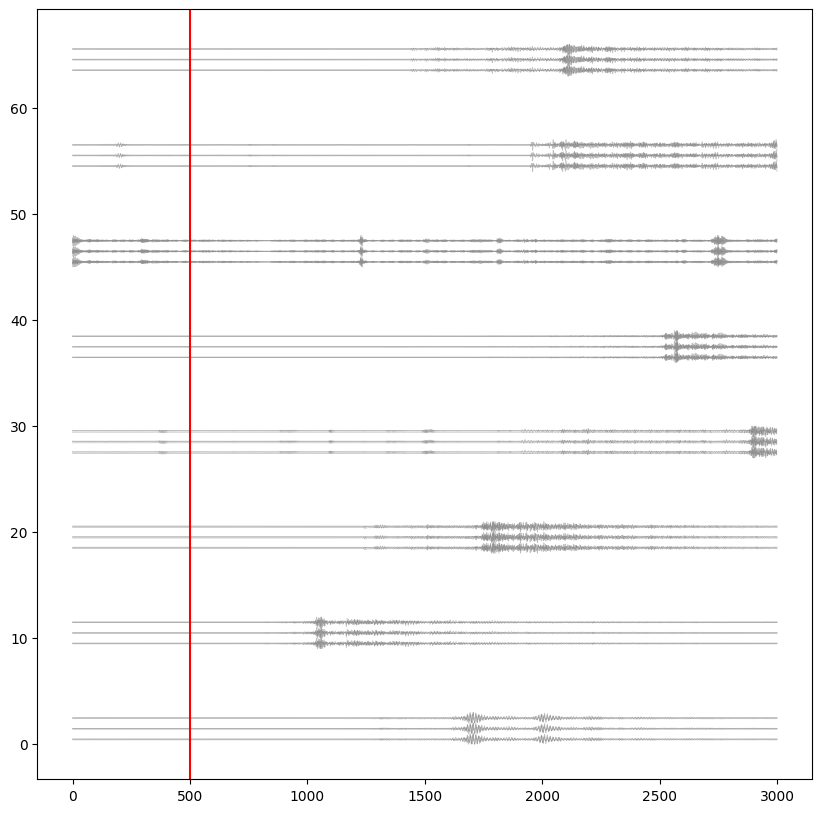

In [372]:
plt.figure(figsize=(10,10))
offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

for i in range(len(stations)):
    s = client_waveforms.get_waveforms(network="7D", station=stations['id'][i], channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
    sdata = np.array(trim_s)[:,:]
    if s[0].stats.channel == 'HH1':
        new_rate = 50
        number_of_samples = round(len(sdata[0]) * float(new_rate) /s[0].stats.sampling_rate)
        sdata = signal.resample(sdata, number_of_samples, axis=-1)
    else:
        pass 
    print(len(sdata[-1]))
    sdata_norm = (sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))
    for ii in range(len(sdata)):
        offsets1  = np.arange(0,len(sdata))
        plt.plot(sdata_norm.T+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.5, lw=0.5)    

plt.axvline(10*sampling_rate,ls='-', c='r')
# plt.xlim(0,3000)


In [345]:
s = client_waveforms.get_waveforms(network="7D", station=stations['id'][3], channel="?H?", year=2012, month=10, day=14)
s = s.select(channel = "[HB]H?")
s.filter(type='bandpass',freqmin=4,freqmax=15)
trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
sdata = np.array(trim_s)[:,:]
sdata_norm = (sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))

In [304]:
UTCDateTime(pick_time[4]) - 10

2012-10-14T07:45:17.532755Z

In [306]:
UTCDateTime(pick_time[4]) + 50

2012-10-14T07:46:17.532755Z

In [322]:
s[0].stats.sampling_rate

125.0

In [313]:
s[0].stats.channel

'HH1'

In [325]:
len(s[-1])

10800000

In [327]:
s[0].stats.sampling_rate

50.0

In [316]:
s[0].stats.channel

'BH1'

In [328]:
len(s[-1])

4320000

In [334]:
s = signal.decimate(s, 125/50, axis=-1)

TypeError: 'float' object cannot be interpreted as an integer

In [347]:
np.array(s)

array([[ 6.53523096e+03,  4.61324772e+04,  1.52231888e+05, ...,
        -1.06255470e+01, -9.86627295e+00, -6.02345531e+00],
       [ 6.53190434e+03,  4.61089415e+04,  1.52153909e+05, ...,
         1.37355550e+01,  1.90139271e+01,  2.01969418e+01],
       [ 6.52818872e+03,  4.60829400e+04,  1.52069132e+05, ...,
         3.14802318e+00,  1.09117554e+00, -2.14952779e-01]])

In [336]:
int(125/50)

2

In [341]:
new_rate = 50
number_of_samples = round(len(s[0]) * float(new_rate) / 125)
number_of_samples

4320000

In [343]:
s = signal.resample(s, number_of_samples, axis=-1)
len(s[-1])

4320000

In [344]:
s

array([[  2462.38623471, 233044.98439301, 464110.53741506, ...,
          1483.08879554,  -2179.54788349,   3318.34370584],
       [  2468.8118825 , 232923.5218896 , 463865.01591711, ...,
          1457.49361998,  -2182.27131719,   3345.41508889],
       [  2461.03433155, 232796.35085515, 463629.50754207, ...,
          1486.64472459,  -2165.8465117 ,   3327.18366886]])

In [388]:
s = client_waveforms.get_waveforms(network="7D", station=stations['id'][3], channel="?H?", year=2012, month=10, day=14)
s = s.select(channel = "[HB]H?")
s.filter(type='bandpass',freqmin=4,freqmax=15)
trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
sdata = np.array(trim_s)[:,:]
print(len(sdata[-1]))

new_rate = 50
number_of_samples = round(len(sdata[0]) * float(new_rate) /s[0].stats.sampling_rate)
sdata = signal.resample(sdata, number_of_samples, axis=-1)
print(len(sdata[-1]))

7501
3000


In [400]:
trim_s[0].times(reftime=UTCDateTime(pick_time[4]) - 10)

array([-2.8860000e-03,  1.7114000e-02,  3.7114000e-02, ...,
        5.9957114e+01,  5.9977114e+01,  5.9997114e+01])

In [403]:
UTCDateTime(pick_time[4])

2012-10-14T07:45:27.532755Z

In [405]:
trim_s.trigger('recstalta',sta=1, lta=4)

3 Trace(s) in Stream:
7D.M14B..BH1 | 2012-10-14T07:45:17.529869Z - 2012-10-14T07:46:17.529869Z | 50.0 Hz, 3001 samples
7D.M14B..BH2 | 2012-10-14T07:45:17.529869Z - 2012-10-14T07:46:17.529869Z | 50.0 Hz, 3001 samples
7D.M14B..BHZ | 2012-10-14T07:45:17.529869Z - 2012-10-14T07:46:17.529869Z | 50.0 Hz, 3001 samples

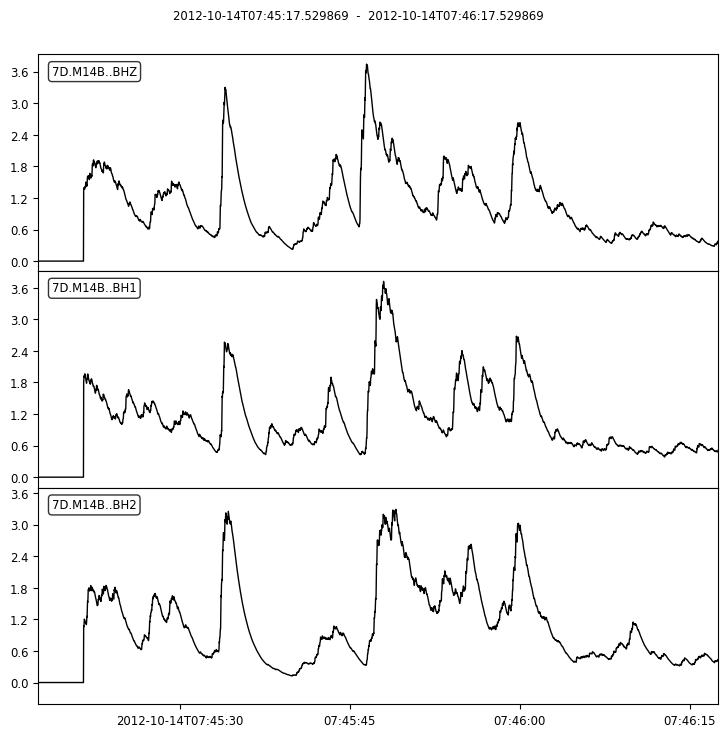

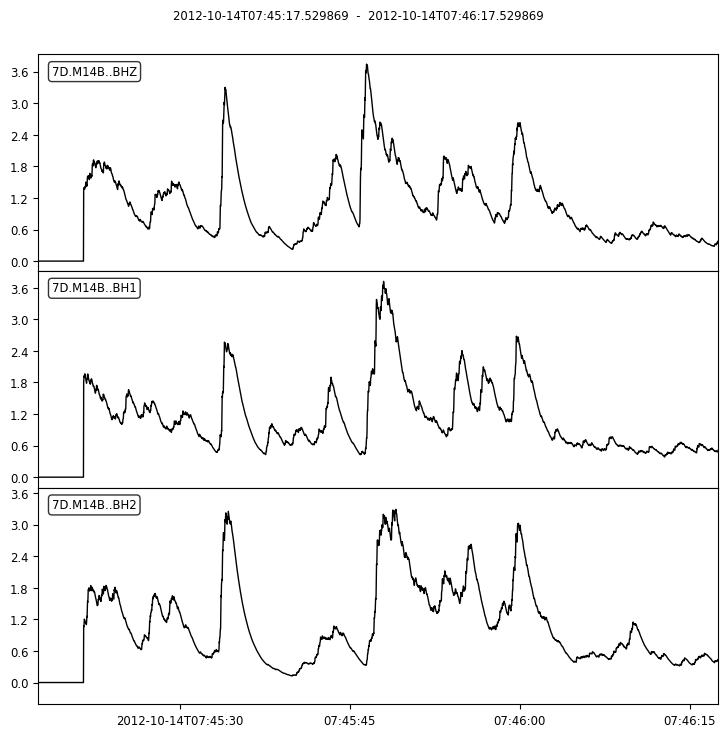

In [406]:
trim_s.plot()

Text(0.5, 1.0, '2012-10-14 07:45:27.532755+00:00')

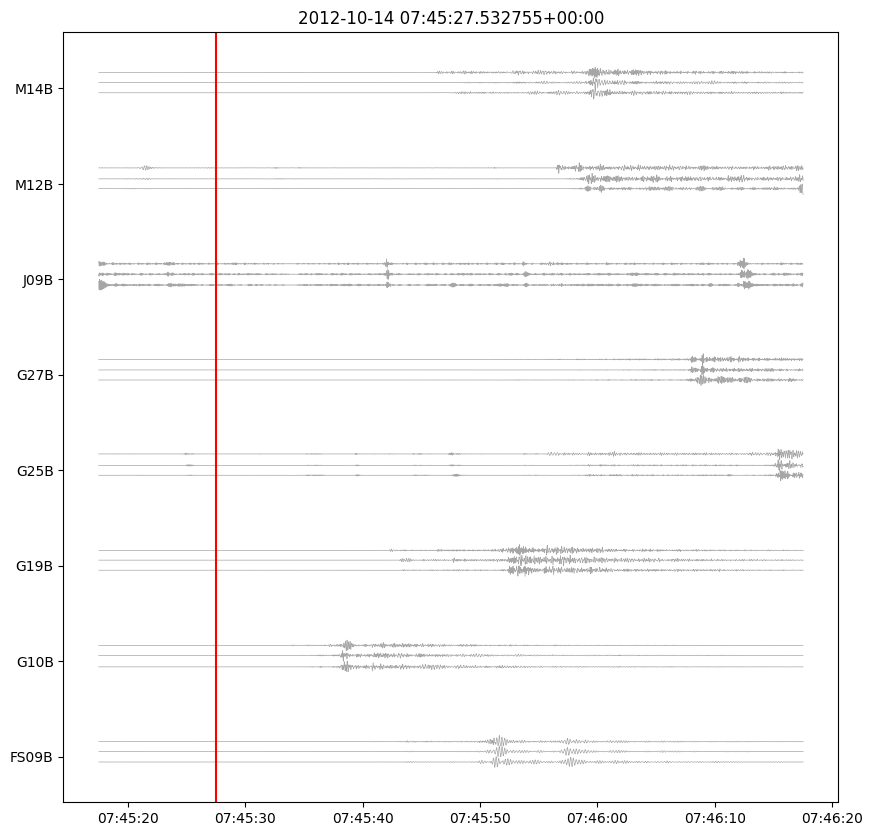

In [408]:
plt.figure(figsize=(10,10))
offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

for i in range(len(stations)):
    s = client_waveforms.get_waveforms(network="7D", station=stations['id'][i], channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    if s[0].stats.channel == 'HH1':
        s = s.resample(50)
    else:
        pass 
    
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
    sdata = np.array(trim_s)[:,:]
    sdata_norm = (sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))
    
    for ii in range(len(sdata)):
        offsets1  = np.arange(0,len(sdata))
        plt.plot(trim_s[ii].times(type='utcdatetime'), sdata_norm[ii]+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.7, lw=0.5)    
    

plt.yticks(offsets2+1, stations['id'])
plt.axvline(pick_time[4],ls='-', c='r')
plt.title(pick_time[4])

# plt.xlim(0,3000)


In [374]:
np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

array([ 0,  9, 18, 27, 36, 45, 54, 63])

In [375]:
stations['id']

0    FS09B
1     G10B
2     G19B
3     G25B
4     G27B
5     J09B
6     M12B
7     M14B
Name: id, dtype: object

In [379]:
all_picks, all_detections = model.classify(sdata)

NameError: name 'model' is not defined

In [381]:
picks_G25B =  pd.read_csv("~/notebooks/data/catalogs_elep_filtered_stations_20121001_to_20121031/G25B_20121014.csv",index_col=0)
picks_G25B

,event_id,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_onset,trace_P_onset,trace_snr_db,trace_s_arrival,trace_p_arrival
0,,,7D,,G25B,NaN,41.919899,-124.586098,-430.0,,125.0,2012-10-14T00:00:00.005500Z,,,,,,NaN,2012-10-14T00:03:30.445500Z
1,,,7D,,G25B,NaN,41.919899,-124.586098,-430.0,,125.0,2012-10-14T00:00:00.005500Z,,,,,,NaN,2012-10-14T00:04:36.389500Z
2,,,7D,,G25B,NaN,41.919899,-124.586098,-430.0,,125.0,2012-10-14T00:00:00.005500Z,,,,,,NaN,2012-10-14T00:07:18.341500Z
3,,,7D,,G25B,NaN,41.919899,-124.586098,-430.0,,125.0,2012-10-14T00:00:00.005500Z,,,,,,NaN,2012-10-14T00:07:33.725500Z
4,,,7D,,G25B,NaN,41.919899,-124.586098,-430.0,,125.0,2012-10-14T00:00:00.005500Z,,,,,,NaN,2012-10-14T00:09:29.997500Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,,,7D,,G25B,NaN,41.919899,-124.586098,-430.0,,125.0,2012-10-14T00:00:00.005500Z,,,,,,2012-10-14T23:22:47.917500Z,NaN
700,,,7D,,G25B,NaN,41.919899,-124.586098,-430.0,,125.0,2012-10-14T00:00:00.005500Z,,,,,,2012-10-14T23:23:26.037500Z,NaN
701,,,7D,,G25B,NaN,41.919899,-124.586098,-430.0,,125.0,2012-10-14T00:00:00.005500Z,,,,,,2012-10-14T23:24:15.197500Z,NaN
702,,,7D,,G25B,NaN,41.919899,-124.586098,-430.0,,125.0,2012-10-14T00:00:00.005500Z,,,,,,2012-10-14T23:24:34.013500Z,NaN


In [382]:
pick_time[4]

Timestamp('2012-10-14 07:45:27.532755+0000', tz='UTC')

## Plot the associated events on a map

In [422]:
import pygmt

fig = pygmt.Figure()
grid = pygmt.datasets.load_earth_relief(resolution="15s", region=[-126, -124, 40, 43])
# fig.shift_origin(yshift="10c")
fig.grdimage(grid=grid, projection="M15c", frame="a", cmap="geo", transparency = 50)
fig.plot(x = [-125., -125.5], y = [42., 42.4],  
         color = 'red', size = [1, 1], style = "c", pen = "black")
fig.show()

GMTCLibNotFoundError: Error loading GMT shared library at 'libgmt.so'.
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/lib-dynload/../../libssl.so.3: version `OPENSSL_3.2.0' not found (required by /home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/lib-dynload/../.././libcurl.so.4)